# Training with Augmented data

## Classification, determining good/bad galaxy images

In this notebook, we train a VGG model using the augmented data. Data augmentation has been done separately in another code and the output data has been stored on disk for the purpose of the following analysis.

128x128 images are used for this analysis, which are in grayscale (g,r,i filter) or colorful (RGB). All images are presented in 3 channels. For grayscale images, all three channels are the same.

labels are either 0 or 1.
- 0: galaxy images with well defined and measured inclinations, that are used for the distance analysis in a separate research
- 1: galaxies that are flagged to be either face-on (inclinations less than 45 degrees from face-on), or to have poor image quality. Deformed galaxies, non-spiral galaxies, confused images, multiple galaxies in a field, galaxy images that are contaminated with bright foreground stars have been also flagged and have label `1`.

We adopt the same network trained to determine inclinations. Here for binary classification, the last layer activation functions has been changed to `Softmax` with `sparse categorical entropy` as the loss function.

### Objective:

The goal is to train a network for automatic rejection of unaccepted galaxies. These galaxies can be later manually studied or investigated by human users.

In [1]:
import sys, os, gc
import subprocess
from math import *
import numpy as np
from datetime import *
from pylab import *
import random
from datetime import datetime
import json
import imgaug as ia
import imgaug.augmenters as iaa
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.utils import to_categorical

In [2]:
def vgg(input_shape=(128, 128, 3)):


    model = tf.keras.models.Sequential(name='VGG')

    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, name='conv1'))
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', name='conv2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv3'))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv4'))
    model.add(tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))
    model.add(tf.keras.layers.Dropout(0.25))

    ## Fully connected layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu', name='fc_2'))
    model.add(tf.keras.layers.Dense(32, activation='relu', name='fc_4'))
    model.add(tf.keras.layers.Dense(8, activation='relu', name='fc_5'))
    
    # output layer
    model.add(tf.keras.layers.Dense(2, activation='softmax'))

    return model

def esn_shuffle(array, seed=0):
        np.random.seed(seed)
        np.random.shuffle(array)
        return array

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)


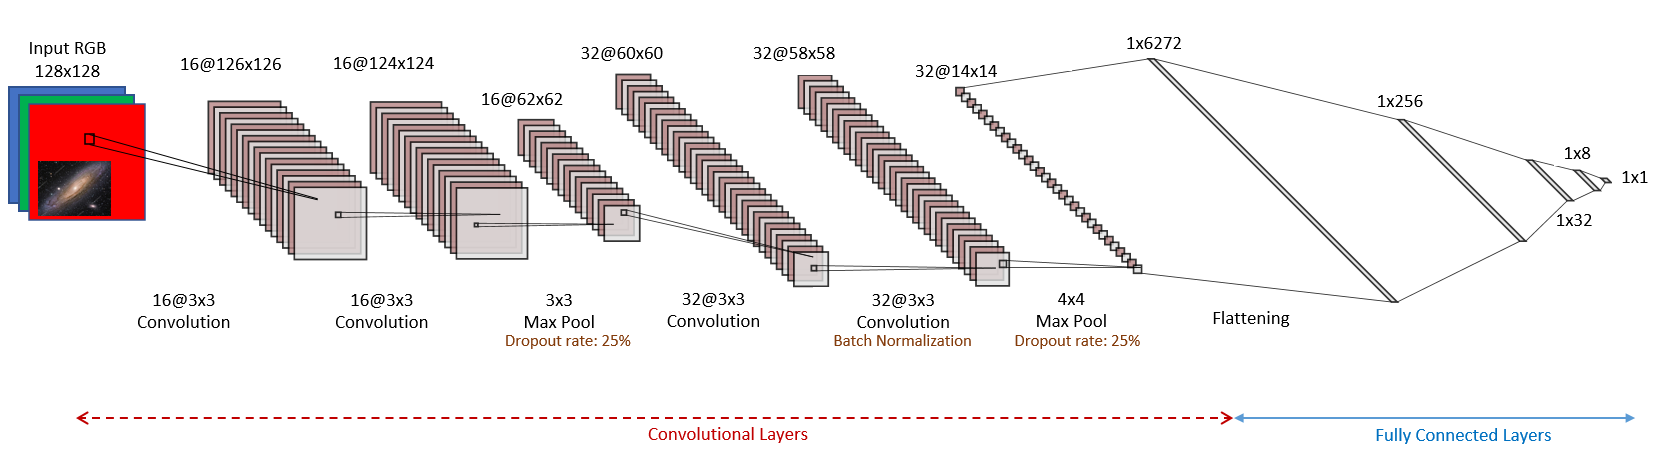

In [3]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename = "./model4_network.png")

In [4]:
model = vgg()
model.summary()

Model: "VGG"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 126, 126, 16)      448       
_________________________________________________________________
conv2 (Conv2D)               (None, 124, 124, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 16)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 60, 60, 32)        4640      
_________________________________________________________________
conv4 (Conv2D)               (None, 58, 58, 32)        9248      
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 58, 58, 32)        128     

In [5]:
def esn_shuffle(array, seed=None):
        if seed is not None:
            np.random.seed(seed)
        np.random.shuffle(array)
        return array

In [6]:
seq = iaa.Sequential([
    iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.1))),
    iaa.GammaContrast(gamma=(0.97,1.03)),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 3), per_channel=0.5),
    iaa.Add((-5, 5), per_channel=0.5),
    iaa.Multiply((0.8, 1.2), per_channel=0.5),
    iaa.Sometimes(0.1, iaa.Grayscale(alpha=(0.0, 1.0))),
    iaa.Sometimes(0.50, iaa.Grayscale(alpha=1.)),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Affine(
        rotate=(0, 359),
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)}, 
        mode=ia.ALL, cval=(0, 255))
    ], random_order=True)


seqGray = iaa.Sequential([
    iaa.GammaContrast(gamma=(0.97,1.03)),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Affine(
        rotate=(0, 359),
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)}, 
        mode=ia.ALL, cval=(255, 255))
    ], random_order=True)

### Importing text images

`samples/<filter>_128x128_test_000.npz` have not been already augmented. Therefore we augment them in the same way we prepared the training sample.

In [7]:
%%time 

data = np.load('samples_binary/RGB_128x128_test_000.npz')
images_RGB = data['images'].astype(np.uint8)
labels_RGB = data['labels'] 
pgcIDs_RGB = data['pgcIDs']
N = images_RGB.shape[0]
filter_RGB = np.chararray(N)
filter_RGB[:] = 'c'
data.close() 
del data


data = np.load('samples_binary/g_128x128_test_000.npz')
images_g = data['images'].astype(np.uint8)
labels_g = data['labels'] 
pgcIDs_g = data['pgcIDs']
N = images_g.shape[0]
filter_g = np.chararray(N)
filter_g[:] = 'g'
data.close() 
del data

data = np.load('samples_binary/r_128x128_test_000.npz')
images_r = data['images'].astype(np.uint8)
labels_r = data['labels'] 
pgcIDs_r = data['pgcIDs']
N = images_r.shape[0]
filter_r = np.chararray(N)
filter_r[:] = 'r'
data.close() 
del data

data = np.load('samples_binary/i_128x128_test_000.npz')
images_i = data['images'].astype(np.uint8)
labels_i = data['labels'] 
pgcIDs_i = data['pgcIDs']
N = images_i.shape[0]
filter_i = np.chararray(N)
filter_i[:] = 'i'
data.close() 
del data

CPU times: user 2.89 s, sys: 101 ms, total: 2.99 s
Wall time: 2.99 s


In [8]:
images_gri = np.concatenate((images_g, images_r, images_i))
labels_gri = np.concatenate((labels_g, labels_r, labels_i))
pgcIDs_gri = np.concatenate((pgcIDs_g, pgcIDs_r, pgcIDs_i))
filter_gri = np.concatenate((filter_g, filter_r, filter_i))

N_RGB = len(labels_RGB)
N_gri = len(labels_gri)

In [9]:
ia.seed(100)

indx = esn_shuffle(np.arange(N_gri), seed=200)
images_aug = seqGray(images=images_gri[indx][:N_RGB,:,:,:])
labels_aug = labels_gri[indx][:N_RGB]
pgcIDs_aug = pgcIDs_gri[indx][:N_RGB]
filter_aug = filter_gri[indx][:N_RGB]

n = len(images_aug)
p = int(n/2)
images_aug[:p] = 255 - images_aug[:p]

ia.seed(200)

images_aug = np.concatenate((seq(images=images_RGB),images_aug))
labels_aug = np.concatenate((labels_RGB,labels_aug))
pgcIDs_aug = np.concatenate((pgcIDs_RGB,pgcIDs_aug))
filter_aug = np.concatenate((filter_RGB,filter_aug))

indx = np.arange(len(images_aug))
indx = esn_shuffle(indx, seed=100)
images_test_aug = images_aug[indx]
labels_test_aug = labels_aug[indx]
pgcIDs_test_aug = pgcIDs_aug[indx]
filter_test_aug = filter_aug[indx]

## Histogram of the binary labels

The number of rejected galaxies is almost 1/3 of that for the accepted galaxies.
Out of the entire set of ~20,000 galaxies we studies in our project, ~5,000 have been rejected due to different issues.

**Note:** The following histogram has been constructed based on the test sample that mimics the original galaxy sample. The training batches on the other hand, have been augmented to retain an equal balance between rejected and accepted data points. 

Text(0, 0.5, 'No. of galaxies')

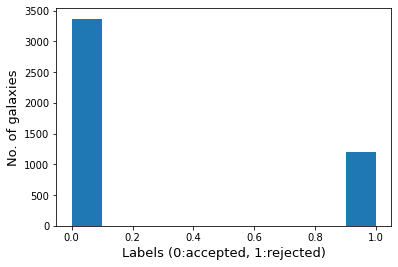

In [10]:
plt.hist(labels_test_aug)

plt.xlabel("Labels (0:accepted, 1:rejected)", fontsize=13)
plt.ylabel("No. of galaxies", fontsize=13)

### Batch number generation

We have 50 batches of training data, each stored in a separate `npz` file on the disk.
Each grand Epoch includes all 50 random iterations that cover the entire training sample. Within each epoch, batches are fed to the network in different orders.
Below, we generate 60 grand epochs of 50 small iterations. Each iteration covers one training sub-sample in `npz` format.

In [11]:
batches = esn_shuffle(np.arange(50), seed=20)

for i in range(1,60):
    batches = np.concatenate((batches, esn_shuffle(np.arange(50), seed=i*20))) 

batches, len(batches)

(array([12, 14,  4, ..., 14, 15, 45]), 3000)

## Training Process

- *zp_dir:* Folder that contains all 50 training batches in `npz` format
- *ckpt_dir:* Folder to save the weight numbers of the network after each iteration


Advancing the training process at each step consists of

1.  Reconstruction of the model as it is at the end of the previous step
2.  Reading the `npz` file that holds the corresponding batch
3.  Training the model for one epoch (moving forward just for 1 iteration)
4.  Updating the JSON file that contains the desired network metrics
5.  Saving the weight values of the model for the use in the next iteration


The input data directory name is formatted as `Uset<index>_npz`, where `U` stands for the sample with uniform distribution of inclinations. `<index>` is codes as following:
- `index = 0` if all training galaxies are taken to construct the network.
- `index = 1, 2, and 3` if `2/3` of the training galaxies (chosen randomly with replacement) are adopted to train the network. The `index` number is used to label all corresponding output directories that hold the network weight numbers and other relevant outputs.  

In [12]:
zp_dir = 'Uset0_binary_npz/'
ckpt_dir = 'U0_model04_binary_ckpt/'

def trainer(iter, batches, suffix=None):

  if suffix is None:
    suffix = ''

  batchNo = batches[iter]
  if True: 

    vgg_model = vgg()
    vgg_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    if iter>0:

      vgg_model = vgg()
      vgg_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
      vgg_model.load_weights(ckpt_dir+str(iter-1)+suffix+".ckpt")

      # if batchNo % 2 == 0 : 
      #   for layer in vgg_model.layers[:-1]:
      #     layer.trainable = False

      with open(ckpt_dir+'evalDict'+suffix+'.json') as json_file:
        evalDict = json.load(json_file)
    else:
      evalDict = {}


    print(iter, batchNo)


    batchFile = npzname = '128x128_train_aug_'+'%02d'%(batchNo+1)+'.npz'
    data = np.load(zp_dir + batchFile)
    images_train_aug = data['images'].astype(np.uint8)
    labels_train_aug = data['labels']
    pgcIDs_train_aug = data['pgcIDs']
    data.close() 
    del data

    
    n_epochs=1
    vgg_model.fit(images_train_aug, labels_train_aug, 
                                      epochs=n_epochs, batch_size=64, 
                                      validation_data=(images_test_aug, labels_test_aug),
                                      verbose=1, shuffle=True)
    evalDict[iter] = {} 
    for key in vgg_model.history.history:
      evalDict[iter][key] = vgg_model.history.history[key][0]
    evalDict[iter]["batchNo"] = batchNo
    evalDict[iter]["batchFile"] = batchFile
    
    with open(ckpt_dir+"evalDict"+suffix+".json", "w", encoding ='utf8') as outfile:
      json.dump(evalDict, outfile, allow_nan=True, cls=NpEncoder)
    
    vgg_model.save_weights(ckpt_dir+str(iter)+suffix+".ckpt")

    del vgg_model
    tf.keras.backend.clear_session()
    del images_train_aug 
    del labels_train_aug
    del pgcIDs_train_aug

    gc.collect()

    return evalDict

### Training the network for large enough iterations

If the training process doesn't improve the evaluations metrics on the test (evaluation) set, we stop the training process. 

In [ ]:
with tf.device('/gpu:0'):
    for i in range(1133,2000):
        trainer(i, batches)

1133 41
313/313 [==============================] - 10s 32ms/step - loss: 0.1815 - accuracy: 0.9255 - val_loss: 0.4868 - val_accuracy: 0.8479
1134 3
313/313 [==============================] - 7s 21ms/step - loss: 0.1789 - accuracy: 0.9280 - val_loss: 0.3681 - val_accuracy: 0.8678
1135 25
313/313 [==============================] - 7s 21ms/step - loss: 0.1885 - accuracy: 0.9223 - val_loss: 0.3520 - val_accuracy: 0.8737
1136 20
313/313 [==============================] - 7s 21ms/step - loss: 0.1772 - accuracy: 0.9264 - val_loss: 0.3426 - val_accuracy: 0.8748
1137 13


In [13]:
import pandas as pd

with open(ckpt_dir+"evalDict.json") as json_file:
        evalDict = json.load(json_file)

df =  pd.DataFrame.from_dict(evalDict).T   

df.tail()

,loss,accuracy,val_loss,val_accuracy,batchNo,batchFile
1132,0.184685,0.9242,0.322099,0.878556,29,128x128_train_aug_30.npz
1133,0.181526,0.92545,0.486842,0.847921,41,128x128_train_aug_42.npz
1134,0.178852,0.92795,0.368076,0.867834,3,128x128_train_aug_04.npz
1135,0.188464,0.9223,0.351971,0.873742,25,128x128_train_aug_26.npz
1136,0.177181,0.9264,0.34257,0.874836,20,128x128_train_aug_21.npz


After about 200 iterations, the loss function of the training sample decreases while the performance gets worse on the test sample. This means that over-training the network after this point doesn't improve the outcome.

We decide to use the weight numbers at snapshot #200.

Text(0, 0.5, 'Accuracy')

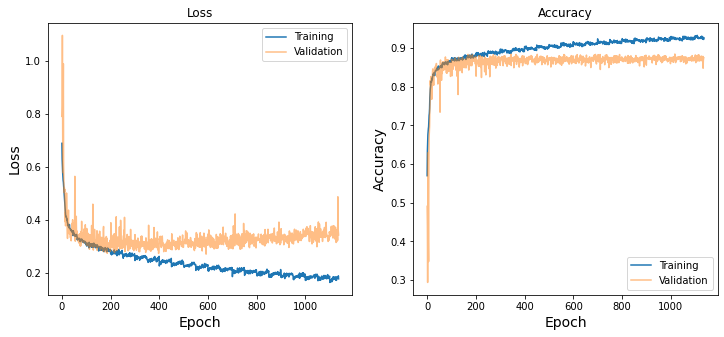

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

epochs = np.arange(len(df))

ax[0].plot(epochs, df.loss.values, label='Training')
ax[0].plot(epochs, df.val_loss, label='Validation', alpha=0.5)
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch', fontsize=14)
ax[0].set_ylabel('Loss', fontsize=14)

ax[1].plot(epochs, df.accuracy.values, label='Training')
ax[1].plot(epochs, df.val_accuracy, label='Validation', alpha=0.5)
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

## The network snapshot at step #200 to make predictions

In [20]:
vgg_model = vgg()
vgg_model.load_weights(ckpt_dir+"200.ckpt")
labels_test_aug_predict = vgg_model.predict(images_test_aug)

### Visualizing galaxy images

Here, we show the first 100 galaxy images in the test sample. In each panel, cyan label is the galaxy ID in the *Principal Galaxy  Catalog* (PGC), and green and red labels represent the actual and predicted labels. Magenta integers labels the panels for further reference in the text. Predicted labels (red percentages) denote the rejection probability of a galaxy by users. 

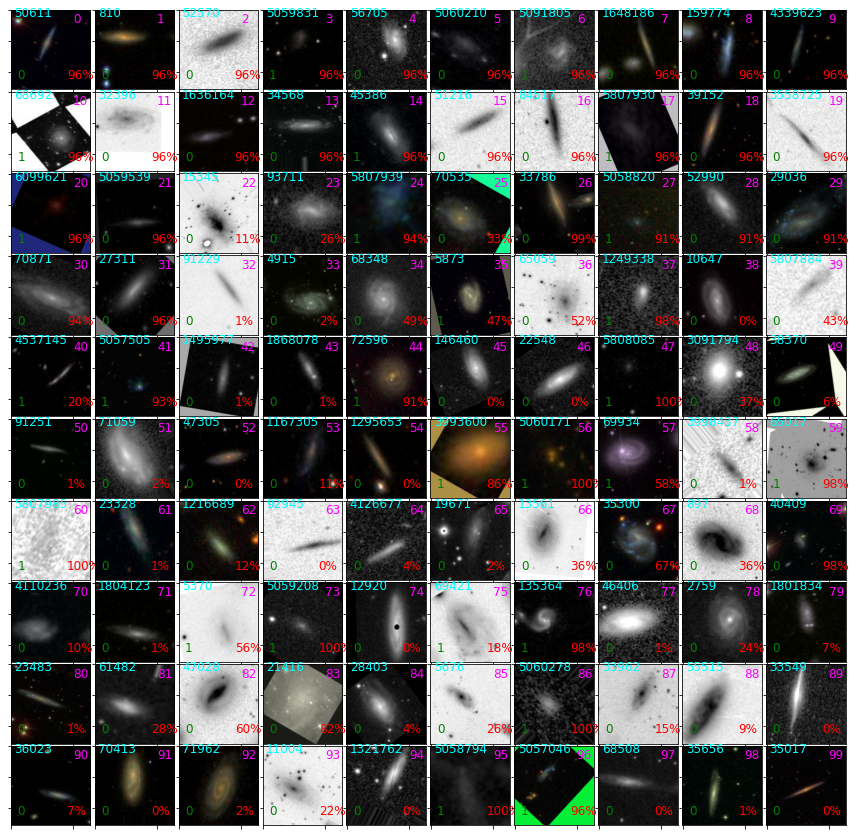

In [25]:
n = 10
m = 10

fig, axes = plt.subplots(nrows=n, ncols=m, figsize=(15,15)) 

t = 0 
for i in range(n):
    for j in range(m):

        ax = axes[i][j]
        ax.imshow(images_test_aug[t,:,:])

        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        
        ax.text(10, 110, "%d"%labels_test_aug[t], color='green', fontsize=12)
        ax.text(100, 20, t, color='magenta', fontsize=12)
        ax.text(85, 110, "%d"%(np.round(labels_test_aug_predict[t][1]*100))+'%', color='red', fontsize=12)
        ax.text(5, 15, pgcIDs_test_aug[t], color='cyan', fontsize=12)
        
        t+=1

plt.subplots_adjust(hspace=0.03, wspace=0.03)